In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def remove_i(x, i):
    """Drops the ith element of an array."""
    shape = (x.shape[0]-1,) + x.shape[1:]
    y = np.empty(shape, dtype=float)
    y[:i] = x[:i]
    y[i:] = x[i+1:]
    return y

def a(i, x, G, m):
    """The acceleration of the ith mass."""
    x_i = x[i]
    x_j = remove_i(x, i)
    m_j = remove_i(m, i)
    diff = x_j - x_i
    mag3 = np.sum(diff**2, axis=1)**1.5
    result = G * np.sum(diff * (m_j / mag3)[:,np.newaxis], axis=0)
    return result

In [6]:
from multiprocessing import Pool

def timestep_i(args):
    """Computes the next position and velocity for the ith mass."""
    i, x0, v0, G, m, dt = args
    a_i0 = a(i, x0, G, m)
    v_i1 = a_i0 * dt + v0[i]
    x_i1 = a_i0 * dt**2 + v0[i] * dt + x0[i]
    return i, x_i1, v_i1

In [7]:
def timestep(x0, v0, G, m, dt, pool):
    """Computes the next position and velocity for all masses given 
    a initial conditions and a time step size.
    """
    N = len(x0)
    tasks = [(i, x0, v0, G, m, dt) for i in range(N)]
    results = pool.map(timestep_i, tasks)
    x1 = np.empty(x0.shape, dtype=float)
    v1 = np.empty(v0.shape, dtype=float)
    for i, x_i1, v_i1 in results:
        x1[i] = x_i1
        v1[i] = v_i1
    return x1, v1

def initial_cond(N, D):
    """Generates initial conditions for N unity masses at rest 
    starting at random positions in D-dimensional space.
    """
    x0 = np.random.rand(N, D)
    v0 = np.zeros((N, D), dtype=float)
    m = np.ones(N, dtype=float)
    return x0, v0, m    

In [8]:
def makefig(x, v, t):
    plt.plot(x[:,0], x[:,1], 'ro')
    if not np.all(v == 0.0):
        plt.quiver(x[:,0], x[:,1], v[:,0], v[:,1])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Time t = {0}'.format(t))
    plt.savefig('n-body-t{0}.svg'.format(t))

In [9]:
%%time
x0, v0, m = initial_cond(10, 2)
pool = Pool(4)
x1, v1 = timestep(x0, v0, 1.0, m, 1.0e-3, pool)
del pool

CPU times: user 16 ms, sys: 16 ms, total: 32 ms
Wall time: 33.8 ms


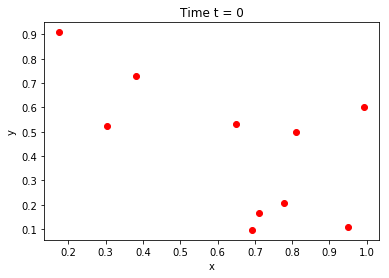

In [10]:
makefig(x0, v0, 0)

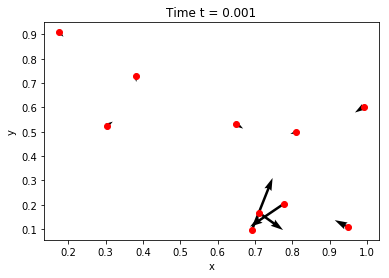

In [11]:
makefig(x1, v1, 1e-3)

In [12]:
def simulate(P, N, D, S, G, dt):
    x0, v0, m = initial_cond(N, D)
    pool = Pool(P)
    for s in range(S):
        x1, v1 = timestep(x0, v0, G, m, dt, pool)
        x0, v0 = x1, v1

In [23]:
%%time
import time
Ps = [1, 2, 4, 8]
runtimes = []
for P in Ps:
    print("running", P)
    start = time.time()
    simulate(P, 16, 3, 30, 1.0, 1e-3)
    stop = time.time()
    runtimes.append(stop - start)
print(runtimes)

running 1
running 2
running 4
running 8
[0.05733346939086914, 0.07181286811828613, 0.07687926292419434, 0.09567856788635254]
CPU times: user 124 ms, sys: 80 ms, total: 204 ms
Wall time: 304 ms


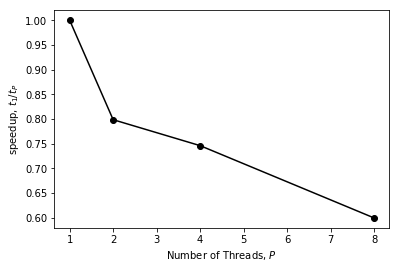

In [24]:
rts = runtimes[0] / np.array(runtimes) 
plt.plot(Ps, rts, 'ko-')
plt.xlabel('Number of Threads, $P$')
plt.ylabel('speedup, $t_1/t_P$')
plt.savefig('n-body-thread-speedup.svg')

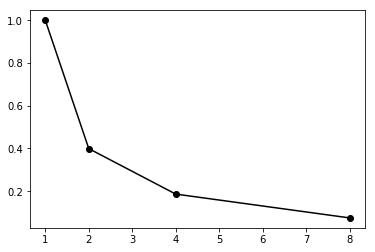

In [25]:
plt.plot(Ps, rts / Ps, 'ko-')

In [26]:
rts

array([1.        , 0.7983732 , 0.74575987, 0.59923001])

In [27]:
rts[1:] / rts[:-1]

array([0.7983732 , 0.93409933, 0.80351603])

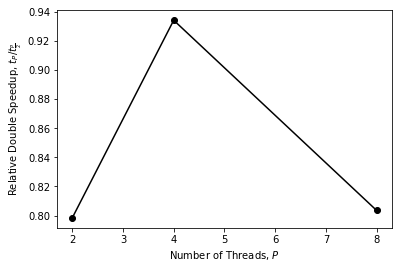

In [28]:
plt.plot(Ps[1:], rts[1:] / rts[:-1], 'ko-')
plt.xlabel('Number of Threads, $P$')
plt.ylabel('Relative Double Speedup, $t_P/t_{\\frac{P}{2}}$')
plt.savefig('n-body-thread-double-speedup.svg')